In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os, sys
workdir_path = '/content/drive/My Drive/Python/ICA/02_VGG16_dogs_cats'
os.chdir(workdir_path)
sys.path.append(workdir_path)

In [0]:
%%bash 

rm -rf transfer_learning_utils.py
wget -O transfer_learning_utils.py https://github.com/crismunoz/DeepLearningExamples/raw/master/week1/transfer_learning_utils.py

--2019-11-29 18:40:05--  https://github.com/crismunoz/DeepLearningExamples/raw/master/week1/transfer_learning_utils.py
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/crismunoz/DeepLearningExamples/master/week1/transfer_learning_utils.py [following]
--2019-11-29 18:40:05--  https://raw.githubusercontent.com/crismunoz/DeepLearningExamples/master/week1/transfer_learning_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3668 (3.6K) [text/plain]
Saving to: ‘transfer_learning_utils.py’

     0K ...                                                   100% 3.95M=0.001s

2019-11-29 18:40:05 (3.95 MB/s) 

In [0]:
from keras.models import Model, Input, Sequential
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.applications import  VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras.optimizers import SGD
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
from keras import losses
import keras
from keras.optimizers import RMSprop

import pickle
import cv2
import numpy as np
from PIL import Image
from IPython.display import Image
from random import randint
import matplotlib.pylab as plt
from transfer_learning_utils import *
from numpy import argmax
from numpy.random import randint    # only to generate a random nuymber ar end

import datetime

import os, cv2, re, random
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import backend as K
from sklearn.model_selection import train_test_split
from itertools import cycle, islice

In [0]:
pretrained_model = VGG16(weights="imagenet", include_top=True)

for i, layer in enumerate(pretrained_model.layers):
    print(i , layer.name, layer.output_shape)





553467904/553467096 [==============================] - 5s 0us/step






0 input_1 (None, 224, 224, 3)
1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
3 block1_pool (None, 112, 112, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
6 block2_pool (None, 56, 56, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
10 block3_pool (None, 28, 28, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
14 block4_pool (None, 14, 14, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)
18 block5_pool (None, 7, 7, 512)
19 flatten (None, 25088)
20 fc1 (None, 4096)
21 fc2 (None, 4096)
22 predictions (None, 1000)


In [0]:
VGG16_sub=Model(inputs  = pretrained_model.input,
                outputs = pretrained_model.get_layer('flatten').output,
                name= 'model_sub_VGG16')
VGG16_sub.summary()

Model: "model_sub_VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)   

Abrir o dataset :

In [0]:
from random import shuffle

img_width = 224
img_height = 224
total_images_train=4200
total_images_test=800
total_images=total_images_train+total_images_test
batch_size=50

TRAIN_DIR = 'train/'
TEST_DIR = 'test/'
train_images_dogs_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
test_images_dogs_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset

# test_images_dogs_cats = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

shuffle(train_images_dogs_cats)
train_images_dogs_cats = train_images_dogs_cats[0:total_images_train]


shuffle(test_images_dogs_cats)
test_images_dogs_cats = test_images_dogs_cats[total_images_train:total_images_train+total_images_test]

# shuffle(test_images_dogs_cats)

In [0]:
def data_generator_cat_dog(list_of_images, batch_size):
    num_steps = len(list_of_images)//batch_size
    while True:
      for i in range(num_steps):
        sublist=list_of_images[(i*batch_size):((i+1)*batch_size)]
        yield get_batch(sublist)

def get_batch(sub_list):
    x=np.zeros((len(sub_list),img_width,img_height,3))
    y=np.zeros((len(sub_list)))
    for i, image in enumerate(sub_list):
        x[i,:]=cv2.resize(cv2.imread(image), (img_width,img_height), interpolation=cv2.INTER_CUBIC)
        x[i,:,:,(0, 1, 2)]=x[i,:,:,(2, 1, 0)]
    
    for i, image in enumerate(sub_list):
        if 'dog' in image:
            y[i]=1
        elif 'cat' in image:
            y[i]=0
        else:
            print('neither cat nor dog name present in images')
    return x, y

In [0]:
train_generator = data_generator_cat_dog(list_of_images=train_images_dogs_cats, batch_size=batch_size)
test_generator = data_generator_cat_dog(list_of_images=test_images_dogs_cats, batch_size=batch_size)

Geração de vetores de imagens (features)

In [0]:
train_steps_per_epoch = total_images_train//batch_size + 1
test_steps_per_epoch = total_images_test//batch_size + 1

increase_by=1
steps_per_epoch = train_steps_per_epoch*increase_by
train_features=[]
train_labels=[]
for i in range(steps_per_epoch):
    print("\rTraining Batches: {}/{}".format(i+1,steps_per_epoch), end="")
    x,y = next(train_generator)
    x=preprocess_input(x)
    train_features.append(VGG16_sub.predict(x))
    train_labels.append(y)

test_features=[]
test_labels=[]
for i in range(test_steps_per_epoch):
    print("\rTest Batches: {}/{}".format(i+1,test_steps_per_epoch), end="")
    x,y = next(test_generator)
    x=preprocess_input(x)
    test_features.append(VGG16_sub.predict(x))
    test_labels.append(y)

train_features = np.concatenate(train_features,axis=0)
train_labels = np.concatenate(train_labels,axis=0)
test_features = np.concatenate(test_features,axis=0)
test_labels = np.concatenate(test_labels,axis=0)

print('\nCreation of vectors image finished!')

Test Batches: 17/17
Creation of vectors image finished!


Como a extração de features é um processo demorado, se recomenda salvar  os features casso seja necessario restar o kernel.

In [0]:
train_data = (train_features,train_labels)
test_data = (test_features,test_labels)
pickle.dump(train_data, open('train_features.p','wb'))
pickle.dump(test_data, open('test_features.p','wb'))

In [0]:
(train_features,train_labels) = pickle.load( open( "train_features.p", "rb" ) )
(test_features,test_labels) = pickle.load( open( "test_features.p", "rb" ))

Definimos nosso classificador:

In [0]:
inputs = Input(VGG16_sub.get_layer('flatten').output_shape[1:])
x = Dense(128)(inputs)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(2)(x)
x = Activation('softmax')(x)
model_cls = Model(inputs=inputs, outputs=x, name='model_classifier')
model_cls.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3211392   
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         


Treinamos o modelo

In [0]:
batch_size=50
epochs=50
from keras import optimizers
from keras.utils import to_categorical

optimizer = optimizers.Adam(lr=0.001)

model_cls.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


history=model_cls.fit(train_features, to_categorical(train_labels),
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(test_features, to_categorical(test_labels)))


scorelt5 = model_cls.evaluate(test_features, to_categorical(test_labels), verbose=0)
print('Test score:', scorelt5[0])
print('Test accuracy:', scorelt5[1])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 4250 samples, validate on 850 samples
Epoch 1/50
4250/4250 [==============================] - 2s 434us/step - loss: 1.4041 - acc: 0.9071 - val_loss: 0.5195 - val_acc: 0.9647
Epoch 2/50
4250/4250 [==============================] - 1s 145us/step - loss: 0.7491 - acc: 0.9520 - val_loss: 0.5788 - val_acc: 0.9624
Epoch 3/50
4250/4250 [==============================] - 1s 143us/step - loss: 0.7986 - acc: 0.9485 - val_loss: 0.4906 - val_acc: 0.9694
Epoch 4/50
4250/4250 [==============================] - 1s 151us/step - loss: 0.7852 - acc: 0.9501 - val_loss: 0.3821 - val_acc: 0.9753
Epoch 5/50
4250/4250 [==============================] - 1s 147us/step - loss: 0.6781 - acc: 0.9565 - val_loss: 0.5120 - val_acc: 0.9682
Epoch 6/50
4250/4250 [==============================] - 1s 140us/step - loss: 0.8743 - acc: 0.9449 - val_loss: 0.6826 - val_acc: 0.9576
Epoch 7/50
4250/4250 [=================

In [0]:
new_model_input = Input(VGG16_sub.get_layer('input_1').output_shape[1:])
out_feat = VGG16_sub(new_model_input)
out_model = model_cls(out_feat)
final_model_sub = Model(inputs=new_model_input, outputs=out_model, name='model_end_sub_models')
final_model_sub.summary()

Model: "model_end_sub_models"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
model_sub_VGG16 (Model)      (None, 25088)             14714688  
_________________________________________________________________
model_classifier (Model)     (None, 2)                 3211650   
Total params: 17,926,338
Trainable params: 17,926,338
Non-trainable params: 0
_________________________________________________________________


In [0]:
layers = VGG16_sub.layers + model_cls.layers[1:]
final_model = Sequential(layers, name='model_end_sub_models')

In [0]:
final_model.summary()

Model: "model_end_sub_models"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 25

In [0]:
def test_prediction():
  x, y = next(train_generator)
  img_test=randint(1, x.shape[0])
  result=final_model_sub.predict(x[img_test,:,:,:].reshape(1,224,224,3))
  if (argmax(result)==1):
    prediction='dog'
  elif (argmax(result)==0):
    prediction='cat'
  else:
    prediction='non'

  if (y[img_test]==1):
    label='dog'
  elif (y[img_test]==0):
    label='cat'
  else:
    label='non'
  print('label: ', label)
  print('prediction: ', prediction)
  plt.imshow(x[img_test].astype(int))

label:  dog
prediction:  dog


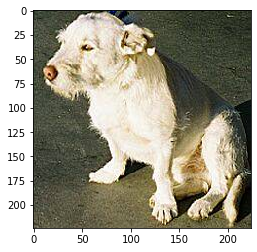

In [0]:
test_prediction()    # max batch size

In [0]:
def test_prediction1(samples_number):
  x, y = next(train_generator)
  result=final_model_sub.predict(x[:samples_number,:,:,:].reshape(samples_number,224,224,3))
  test_result=[]

  for i, res in enumerate(result):
    test_result.append(['a', 'b'])

    # pred
    if (argmax(res)==1):
      test_result[i][1]='dog'
    elif (argmax(res)==0):
      test_result[i][1]='cat'
    else:
      test_result[i][1]='non'
    
    
    # org
    if (y[i]==1):
      test_result[i][0]='dog'
    elif (y[i]==0):
      test_result[i][0]='cat'
    else:
      test_result[i][0]='non'
    # plt.imshow(x[i,:,:,:].astype(int))
    # plt.figure()
  
  fig=plt.figure()
  fig=plt.figure(figsize=(10, 10))
  columns = 4
  rows = (samples_number//4)+1
  print(rows)
  for i, res in enumerate(result):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(x[i].astype(int))
    plt.title(('pred: ' + test_result[i][0] + '\n real: ' + test_result[i][1]), color="w")
  plt.show()
  return test_result

4


<Figure size 432x288 with 0 Axes>

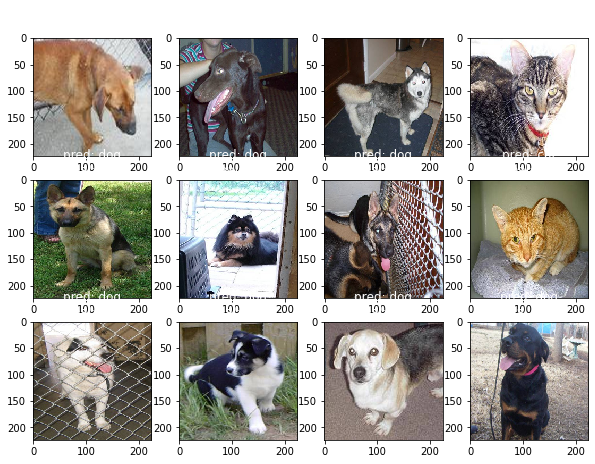

[['dog', 'dog'],
 ['dog', 'dog'],
 ['dog', 'cat'],
 ['cat', 'cat'],
 ['dog', 'dog'],
 ['dog', 'cat'],
 ['dog', 'dog'],
 ['cat', 'cat'],
 ['dog', 'dog'],
 ['dog', 'dog'],
 ['dog', 'dog'],
 ['dog', 'dog']]

In [0]:
test_prediction1(12)

In [0]:
# Save the weights
final_model_sub.save_weights('final_model_weights.h5')

# Save the model architecture
with open('final_model_architecture.json', 'w') as f:
    f.write(final_model_sub.to_json())

# Save the model complete with the weights
final_model_sub.save('final_model_complete.h5')

In [0]:
final_model_sub.summary()

Model: "model_end_sub_models"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
model_sub_VGG16 (Model)      (None, 25088)             14714688  
_________________________________________________________________
model_classifier (Model)     (None, 2)                 3211650   
Total params: 17,926,338
Trainable params: 17,926,338
Non-trainable params: 0
_________________________________________________________________


In [0]:
print(final_model_sub.outputs)
print(final_model_sub.inputs)

[<tf.Tensor 'model_classifier/activation_2/Softmax:0' shape=(?, 2) dtype=float32>]
[<tf.Tensor 'input_3:0' shape=(?, 224, 224, 3) dtype=float32>]


In [0]:
from keras import backend as K
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in final_model_sub.outputs])

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 53 variables.
INFO:tensorflow:Converted 53 variables to const ops.


In [0]:
# Save to ./model/tf_model.pb
tf.train.write_graph(frozen_graph, "" , "final_model_graph_frozen.pb", as_text=False)

'final_model_graph_frozen.pb'

In [0]:
print(final_model_sub.inputs)
print(final_model_sub.outputs)


[<tf.Tensor 'input_3:0' shape=(?, 224, 224, 3) dtype=float32>]
[<tf.Tensor 'model_classifier/activation_2/Softmax:0' shape=(?, 2) dtype=float32>]


In [0]:
! python -m tensorflow.python.tools.optimize_for_inference \
--input final_model_graph_frozen.pb \
--output final_model_graph_optimized.pb \
--input_names=input_3 \
--output_names=model_classifier/activation_2/Softmax \
--placeholder_type_enum=1

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
W1129 18:49:49.047815 140125938702208 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/tools/strip_unused_lib.py:88: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`
W1129 18:49:49.053010 140125938702208 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/tools/optimize_for_inference_lib.py:113: remove_training_nodes (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`
